In [89]:
# General libs
import os                             
import random                         
import matplotlib.pyplot as plt     
%matplotlib inline   
import pandas as pd             
import numpy as np  
!pip install opencv-python
import cv2                            

# ML libs
!pip install keras
!pip install tensorflow
import keras.backend as K
from keras.models import Model, Sequential  
from keras.layers import Input, Flatten, Dropout, Dense, BatchNormalization
from keras.layers import LeakyReLU, Activation, Conv2D, SeparableConv2D, MaxPool2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
print(tf.executing_eagerly())

seed = 69
np.random.seed(seed)
tf.random.set_seed(seed)

True


In [90]:
counter_normal = len(os.listdir(input_path + 'train' + '/NORMAL'))
counter_infect = len(os.listdir(input_path + 'train' +  '/PNEUMONIA'))
print('\nSet: {}, Healthy lungs images: {}, Pneumonia-affected lungs images {}\n'.format('train', counter_normal, counter_infect))

counter_normal = len(os.listdir(input_path + 'test' + '/NORMAL'))
counter_infect = len(os.listdir(input_path + 'test' +  '/PNEUMONIA'))
print('Set: {}, Healthy lungs images: {}, Pneumonia-affected lungs images {}\n'.format('test', counter_normal, counter_infect))

counter_normal = len(os.listdir(input_path + 'val' + '/NORMAL'))
counter_infect = len(os.listdir(input_path + 'val' +  '/PNEUMONIA'))
print('Set: {}, Healthy lungs images: {}, Pneumonia-affected lungs images {}\n'.format('val', counter_normal, counter_infect))


Set: train, Healthy lungs images: 1341, Pneumonia-affected lungs images 3875

Set: test, Healthy lungs images: 234, Pneumonia-affected lungs images 390

Set: val, Healthy lungs images: 8, Pneumonia-affected lungs images 8



Text(0.5, 1, 'Diagnose: Sick - Pneumonia\n')

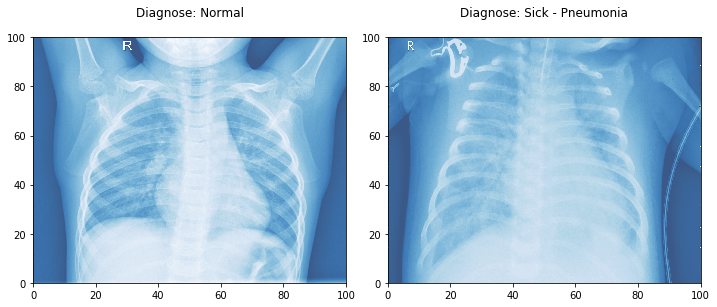

In [109]:
input_path = './chest_xray/chest_xray/'
figure, axis = plt.subplots(1, 2, figsize = (10,4))
axis = axis.ravel()
plt.tight_layout()

set_path = input_path + 'train'
axis[0].imshow(plt.imread(set_path + '/NORMAL/' + os.listdir(set_path + '/NORMAL')[0]),
                      aspect='auto',
                      extent=(0, 100, 0, 100),
                      alpha=0.8,
                      cmap='Blues_r')
axis[0].set_title('Diagnose: Normal\n')

axis[1].imshow(plt.imread(set_path + '/PNEUMONIA/' + os.listdir(set_path + '/PNEUMONIA')[0]), 
                      aspect='auto',
                      extent=(0, 100, 0, 100),
                      alpha=0.8,
                      cmap='Blues_r')
axis[1].set_title('Diagnose: Sick - Pneumonia\n')

In [69]:
def process(dimensions, batch):
  train_datagen = ImageDataGenerator(rescale = 1./255, zoom_range = 0.5, vertical_flip = True)
  test_val_datagen = ImageDataGenerator (rescale= 1./255)

  train_gen = train_datagen.flow_from_directory(directory = input_path + 'train', target_size = (dimensions, dimensions), batch_size = batch, class_mode = 'binary', shuffle = True)
  test_gen = test_val_datagen.flow_from_directory(directory = input_path + 'test', target_size = (dimensions, dimensions), batch_size = batch, class_mode = 'binary', shuffle = True)

  test_data = []
  test_labels = []

  for cond in ['/NORMAL/', '/PNEUMONIA/']:
    for img in (os.listdir(input_path + 'test' + cond)):
      img = plt.imread(input_path + 'test' + cond + img)
      img = cv2.resize(img, (dimensions, dimensions))
      img = np.dstack([img,img,img])
      img = img.astype('float32') / 255
      if cond == '/NORMAL/':
        label = 0
      elif cond == '/PNEUMONIA/':
        label = 1
      test_data.append(img)
      test_labels.append(label)

  test_data = np.array(test_data)
  test_labels = np.array(test_labels)

  return train_gen, test_gen, test_data, test_labels


In [71]:
dimensions = 180
epochs = 12
batch = 64

train_gen, test_gen, test_data, test_labels = process(dimensions, batch)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
inputs = Input(shape=(dimensions, dimensions, 3))

# 1st conv block
x = Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', padding = 'same')(inputs)
x = Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = MaxPool2D(pool_size=(2,2))(x)

# 2nd
x = SeparableConv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = SeparableConv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)

# 3rd
x = SeparableConv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = SeparableConv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)

# 4th
x = SeparableConv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = SeparableConv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = Dropout(rate = 0.2)(x)

# 5th
x = SeparableConv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = SeparableConv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = Dropout(rate = 0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units = 512, activation = 'relu')(x)
x = Dropout(rate = 0.7)(x)
x = Dense(units = 128, activation = 'relu')(x)
x = Dropout(rate = 0.5)(x)
x = Dense(units = 64, activation = 'relu')(x)
x = Dropout(rate = 0.3)(x)

# Output layer
output = Dense(units = 1, activation = 'sigmoid')(x)

# Creating a model and compiling
model = Model(inputs = inputs, outputs = output)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics =['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath = 'best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')



In [7]:
hist = model.fit_generator(train_gen, steps_per_epoch = train_gen.samples // batch_size, epochs = epochs, validation_data = test_gen, validation_steps = test_gen.samples // batch_size, callbacks = [checkpoint, lr_reduce])


Epoch 1/10
163/163 [==============================] - 200s 1s/step - loss: 0.3954 - accuracy: 0.8115 - val_loss: 0.7958 - val_accuracy: 0.6234
Epoch 2/10
163/163 [==============================] - 204s 1s/step - loss: 0.2953 - accuracy: 0.8763 - val_loss: 1.1236 - val_accuracy: 0.6334
Epoch 3/10
163/163 [==============================] - 201s 1s/step - loss: 0.2864 - accuracy: 0.8806 - val_loss: 0.5636 - val_accuracy: 0.6301
Epoch 4/10
163/163 [==============================] - 203s 1s/step - loss: 0.2517 - accuracy: 0.9003 - val_loss: 1.5261 - val_accuracy: 0.6047
Epoch 5/10
163/163 [==============================] - 196s 1s/step - loss: 0.2375 - accuracy: 0.9093 - val_loss: 2.1565 - val_accuracy: 0.6301
Epoch 6/10
163/163 [==============================] - 200s 1s/step - loss: 0.2178 - accuracy: 0.9176 - val_loss: 0.5839 - val_accuracy: 0.8361
Epoch 7/10
163/163 [==============================] - 198s 1s/step - loss: 0.1969 - accuracy: 0.9252 - val_loss: 0.4651 - val_accuracy: 0.8868

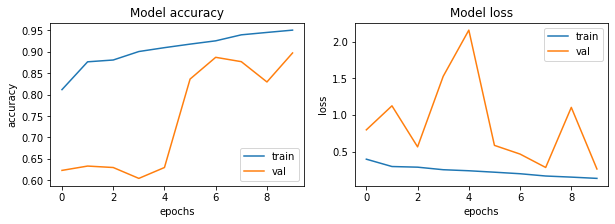

In [9]:
fig, ax = plt.subplots(1,2, figsize = (10,3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
  ax[i].plot(hist.history[met])
  ax[i].plot(hist.history['val_' + met])
  ax[i].set_title('Model {}'.format(met))
  ax[i].set_xlabel('epochs')
  ax[i].set_ylabel(met)
  ax[i].legend(['train', 'val'])

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))* 100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print ('Confusion matrix')
print (cm)

print ('\nTest metrics')
precision = tp/(tp + fp) * 100
recall = tp / (tp + fn) * 100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}%'.format(2* precision * recall / (precision + recall)))

print('\nTrain metric')
print('Train accuracy: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

Confusion matrix
[[193  41]
 [ 18 372]]

Test metrics
Accuracy: 90.5448717948718%
Precision: 90.07263922518159%
Recall: 95.38461538461539%
F1-score: 92.65255292652553%

Train metric
Train accuracy: 95.02
